In [1]:
import numpy as np
import pickle
import pandas as pd
import json
import logging
import argparse
import spacy
import sys
import os
from scispacy.abbreviation import AbbreviationDetector
import scispacy
from scispacy.linking import EntityLinker
from scispacy.umls_linking import UmlsEntityLinker
from scispacy.umls_utils import UmlsKnowledgeBase
from spacy.tokens import Doc, DocBin
from spacy.language import Language
from glob import glob
from copy import deepcopy
from time import time
from pyspark.sql import SparkSession
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import functools
import utils
pd.options.mode.chained_assignment = None
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


from pprint import pprint
from time import time

TypeError: issubclass() arg 1 must be a class

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import logging
logging.basicConfig(format='%(process)d-%(levelname)s-%(message)s')

pd.set_option('display.max_colwidth', None)

In [3]:
client = Client(n_workers=8, threads_per_worker=4, processes=True)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 31.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37189,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 31.29 GiB
Comm: tcp://127.0.0.1:38983,Total threads: 4
Dashboard: http://127.0.0.1:45623/status,Memory: 3.91 GiB
Nanny: tcp://127.0.0.1:41443,


In [4]:
data_set = dd.read_csv('../../mimic-iii/cleaned/notes/NOTESEVENTS_0.csv', encoding="utf-8", engine="python", dtype={"CLEANED_TEXT": str})
len(data_set)

12422

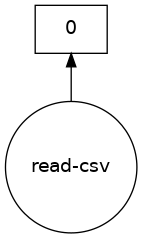

In [5]:
data_set.visualize()

In [6]:
SP_MODEL = spacy.load("en_core_sci_sm")
SP_MODEL.add_pipe("scispacy_linker", config={"linker_name": "umls"})
linker = SP_MODEL.get_pipe("scispacy_linker")

2023-07-11 18:16:54,033 - Loading index from /home/vmadmin/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
2023-07-11 18:16:54,036 - Loading regular index.
2023-07-11 18:17:06,159 - Finished loading index
2023-07-11 18:17:06,161 - Set HNSW query-time parameters:
2023-07-11 18:17:06,162 - ef(Search)         =20
2023-07-11 18:17:06,163 - algoType           =2
2023-07-11 18:17:06,164 - Set HNSW query-time parameters:
2023-07-11 18:17:06,164 - ef(Search)         =200
2023-07-11 18:17:06,165 - algoType           =2
/home/vmadmin/spacy_venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-mai

In [7]:
# @Language.component("annotate")
def annotate_entities_linker_embedded(document):
    '''
    :param document: text to annotate
    :return: annotated file with token level annotations of entities and sentence level annotations of evidence
    '''
    doc_ann = {}
    sentences = []
    sent_entities = []

    for sent_id, sent in enumerate(document.sents):
        for entity in sent.ents:
            entity_annotation = {"name": "{}".format(entity),
                                 "pos": [entity.start, entity.end],
                                 "sent_id": sent_id}
            try:
                linked_codes = []
                linked_entity = {}
                for e in entity._.kb_ents:
                    cui, cui_score = e
                    umls_ent = linker.kb.cui_to_entity[cui]
                    linked_entity[cui] = {}
                    linked_entity[cui]["score"] = np.round(cui_score, 2)
                    for code in umls_ent.types:
                        if code not in linked_codes:
                            styname = linker.kb.semantic_type_tree.get_canonical_name(code)
                            linked_entity[cui]["type_id"] = code
                            linked_entity[cui]["type"] = styname
                            linked_codes.append(code)
                        else:
                            pass
                entity_annotation["linked_umls_entities"] = linked_entity
            except KeyError:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                entity_annotation["linked_umls_entities"] = {}
                logging.warning("Entity - {} can't be found in UMLS".format(entity))
            sent_entities.append(entity_annotation)
        sentences.append([m.text for m in sent])
    doc_ann["Entities"] = sent_entities
    doc_ann["Sents"] = sentences
    return doc_ann

In [8]:
Doc.set_extension("umls_ents", getter=annotate_entities_linker_embedded)

In [55]:
a = "Admission Date: 2151-7-16 Discharge Date: 2151-8-4 Service: ADDENDUM: RADIOLOGIC STUDIES: Radiologic studies also included a chest CT, which confirmed cavitary lesions in the left lung apex consistent with infectious process/tuberculosis. This also moderate-sized left pleural effusion. HEAD CT: Head CT showed no intracranial hemorrhage or mass effect, but old infarction consistent with past medical history. ABDOMINAL CT: Abdominal CT showed lesions of T10 and sacrum most likely secondary to osteoporosis. These can be followed by repeat imaging as an outpatient. First Name8 (NamePattern2) First Name4 (NamePattern1) 1775 Last Name (NamePattern1) , M.D. MD Number(1) 1776 Dictated By:Hospital 1807 MEDQUIST36 D: 2151-8-5 12:11 T: 2151-8-5 12:21 JOB#: Job Number 1808"

d = SP_MODEL(a)
print (np.array(d._.umls_ents))
print(d.sents)
print(d._.umls_ents)

{'Entities': [{'name': 'Admission', 'pos': [0, 1], 'sent_id': 0, 'linked_umls_entities': {'C0184666': {'score': 1.0, 'type_id': 'T058', 'type': 'Health Care Activity'}, 'C0809949': {'score': 1.0}, 'C0559269': {'score': 0.91, 'type_id': 'T079', 'type': 'Temporal Concept'}, 'C0030673': {'score': 0.81}, 'C4684560': {'score': 0.76, 'type_id': 'T170', 'type': 'Intellectual Product'}}}, {'name': 'Discharge', 'pos': [8, 9], 'sent_id': 0, 'linked_umls_entities': {'C0012621': {'score': 1.0, 'type_id': 'T031', 'type': 'Body Substance'}, 'C0030685': {'score': 1.0, 'type_id': 'T058', 'type': 'Health Care Activity'}, 'C0600083': {'score': 1.0}, 'C1546601': {'score': 1.0, 'type_id': 'T170', 'type': 'Intellectual Product'}, 'C2926602': {'score': 1.0, 'type_id': 'T184', 'type': 'Sign or Symptom'}}}, {'name': 'Service', 'pos': [16, 17], 'sent_id': 0, 'linked_umls_entities': {'C0557854': {'score': 1.0, 'type_id': 'T057', 'type': 'Occupational Activity'}, 'C2825316': {'score': 1.0, 'type_id': 'T073', 'ty

In [78]:
#using spacy multiprocess pip function to multiprocess data
nlp = None
def spacyProcess(data, dask=False):
    if dask:
        data.loc[:,"ANNOTATED_TEXT"] = data['CLEANED_TEXT'].apply(lambda x:SP_MODEL(x))
        return data
    # model.add_pipe("annotate", name="retrieve_annotate", last=True)
    # documents = model.pipe(data, n_process=8)
    return documents

In [10]:
data_set.head(n=1, compute=True)

,index,CLEANED_TEXT
0,0,"Admission Date: 2151-7-16 Discharge Date: 2151-8-4 Service: ADDENDUM: RADIOLOGIC STUDIES: Radiologic studies also included a chest CT, which confirmed cavitary lesions in the left lung apex consistent with infectious process/tuberculosis. This also moderate-sized left pleural effusion. HEAD CT: Head CT showed no intracranial hemorrhage or mass effect, but old infarction consistent with past medical history. ABDOMINAL CT: Abdominal CT showed lesions of T10 and sacrum most likely secondary to osteoporosis. These can be followed by repeat imaging as an outpatient. First Name8 (NamePattern2) First Name4 (NamePattern1) 1775 Last Name (NamePattern1) , M.D. MD Number(1) 1776 Dictated By:Hospital 1807 MEDQUIST36 D: 2151-8-5 12:11 T: 2151-8-5 12:21 JOB#: Job Number 1808"


In [79]:
#using dask
documents = data_set[["CLEANED_TEXT"]].map_partitions(spacyProcess, dask=True, meta=pd.DataFrame(columns=["CLEANED_TEXT", "ANNOTATED_TEXT"]))

In [81]:
documents.compute()

2023-07-11 21:14:00,956 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 1 layers.
 0. spacyProcess-2761265c8fef3d1b952ad545d1d3c9ec
>.
Traceback (most recent call last):
  File "/home/vmadmin/spacy_venv/lib/python3.8/site-packages/distributed/protocol/pickle.py", line 77, in dumps
    result = cloudpickle.dumps(x, **dump_kwargs)
  File "/home/vmadmin/spacy_venv/lib/python3.8/site-packages/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/home/vmadmin/spacy_venv/lib/python3.8/site-packages/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
TypeError: cannot pickle 'nmslib.dist.FloatIndex' object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vmadmin/spacy_venv/lib/python3.8/site-packages/distributed/protocol/pickle.py", line 81, in dumps
    result = cloudpickle.dumps(x, **dump_kwargs)
  File "/home/vmadmin/spa

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 1 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x7f1333c96d30>\n 0. spacyProcess-2761265c8fef3d1b952ad545d1d3c9ec\n>')

In [ ]:
#using spacy
data_ = data_set[["CLEANED_TEXT"]].compute()[:2000]
documents = spacyProcess(data_["CLEANED_TEXT"].tolist(), SP_MODEL)

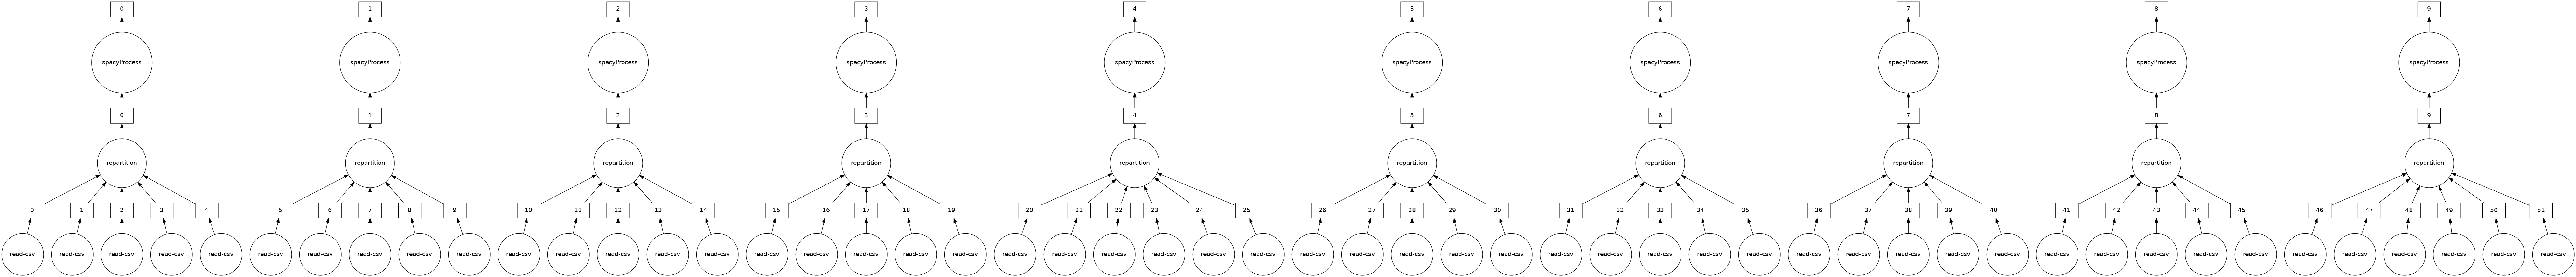

In [16]:
documents.visualize()

In [17]:
documents.head()

2023-07-08 15:27:43,345 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 4 layers.
 0. read-csv-de9d07d1ad8d0309567c7947c12024ee
 1. repartition-10-f4851da8ff3c4825de7279c50121cce7
 2. spacyProcess-13964f314de0659c14356671fc6e837c
 3. head-1-5-spacyProcess-13964f314de0659c14356671fc6e837c
>.
Traceback (most recent call last):
  File "/home/vmadmin/spacy_venv/lib/python3.8/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
TypeError: cannot pickle 'nmslib.dist.FloatIndex' object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vmadmin/spacy_venv/lib/python3.8/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
TypeError: cannot pickle 'nmslib.dist.FloatIndex' object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vmad

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 4 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x7f93b04278b0>\n 0. read-csv-de9d07d1ad8d0309567c7947c12024ee\n 1. repartition-10-f4851da8ff3c4825de7279c50121cce7\n 2. spacyProcess-13964f314de0659c14356671fc6e837c\n 3. head-1-5-spacyProcess-13964f314de0659c14356671fc6e837c\n>')

In [11]:
# def create_linker():
#     return EntityLinker(linker_name="umls")

# Language.factory("scispacy_linker", func=create_linker)

SPACY_MODEL = None
def get_spacy_model():
    global SPACY_MODEL, linker
    if not SPACY_MODEL:
        SPACY_MODEL = spacy.load("en_core_sci_sm")
        #linker = EntityLinker(linker_name="umls")
#         SPACY_MODEL.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})
        #linker = spacy_model.get_pipe("scispacy_linker")
    return SPACY_MODEL

def process_document(text):
    spacy_model = get_spacy_model()
    documents = spacy_model(text)
    return documents

In [12]:
data_spark = data_read_spark.select("CLEANED_TEXT").rdd.flatMap(lambda x: x)

In [13]:
for i in data_spark.collect():
    print(type(i), i)

<class 'str'> Admission Date: 2151-7-16 Discharge Date: 2151-8-4 Service: ADDENDUM: RADIOLOGIC STUDIES: Radiologic studies also included a chest CT, which confirmed cavitary lesions in the left lung apex consistent with infectious process/tuberculosis. This also moderate-sized left pleural effusion. HEAD CT: Head CT showed no intracranial hemorrhage or mass effect, but old infarction consistent with past medical history. ABDOMINAL CT: Abdominal CT showed lesions of T10 and sacrum most likely secondary to osteoporosis. These can be followed by repeat imaging as an outpatient. First Name8 (NamePattern2) First Name4 (NamePattern1) 1775 Last Name (NamePattern1) , M.D. MD Number(1) 1776 Dictated By:Hospital 1807 MEDQUIST36 D: 2151-8-5 12:11 T: 2151-8-5 12:21 JOB#: Job Number 1808 
<class 'str'> Admission Date: 2118-6-2 Discharge Date: 2118-6-14 Date of Birth: Sex: F Service: MICU and then to Doctor Last Name Medicine HISTORY OF PRESENT ILLNESS: This is an 81-year-old female with a history o

In [14]:
process_data_spark = data_spark.map(lambda x:process_document(x))

In [15]:
for doc in process_data_spark.collect():
    for i,sent in enumerate(doc.sents):
        print(i, sent)
    print("=========================")

0 Admission Date: 2151-7-16 Discharge Date: 2151-8-4 Service: ADDENDUM: RADIOLOGIC STUDIES: Radiologic studies also included a chest CT, which confirmed cavitary lesions in the left lung apex consistent with infectious process/tuberculosis.
1 This also moderate-sized left pleural effusion.
2 HEAD CT: Head CT showed no intracranial hemorrhage or mass effect, but old infarction consistent with past medical history.
3 ABDOMINAL CT: Abdominal CT showed lesions of T10 and sacrum most likely secondary to osteoporosis.
4 These can be followed by repeat imaging as an outpatient.
5 First Name8 (NamePattern2) First Name4 (NamePattern1) 1775 Last Name (NamePattern1) , M.D. MD Number(1) 1776 Dictated By:Hospital 1807 MEDQUIST36 D: 2151-8-5 12:11 T: 2151-8-5 12:21 JOB#: Job Number 1808
0 Admission Date: 2118-6-2 Discharge Date: 2118-6-14 Date of Birth: Sex: F Service: MICU and then to Doctor Last Name Medicine HISTORY OF PRESENT ILLNESS: This is an 81-year-old female with a history of emphysema (no

In [39]:
start_time = time()
data = data_read["CLEANED_TEXT"].tolist()
spacy_md = get_spacy_model()
documents = spacy_md.pipe(data)
end_time = time()
print(end_time - start_time)

0.00013709068298339844


In [36]:
# linker1 = EntityLinker(linker_name="umls")
linker2 = UmlsKnowledgeBase()

In [40]:
for document in documents:
    linker2.kb.cui_to_entity
    doc_ann = {}
    sentences = []
    sent_entities = []
    errorsInAnnotation = {}
    for sent_id,sent in enumerate(document.sents):
#         print(sent)
        for entity in sent.ents:
            try:
                linked_entity["kb"] = "UMLS"
#                 print(entity.text)
                umls_concepts1 = linker2.kb.cui_to_entity[entity.text] 
                print(list(umls_concepts1))
                print("\n")
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                errorStr = re.sub(r"<class|>", "", str(exc_type)).strip().replace("'", "")
#                 print("There must be an entity whose code didn't get linked to the UMLS KB", entity)

In [69]:
def annotate_entities(text):
    '''
    :param documents: documents to annotate
    :param model: spacy model to perform entity linking
    :return: annotated file with token level annotations of entities and sentence level annotations of evidence
    '''
    spacy_model = get_spacy_model()
    linker
    document = spacy_model(text)

    doc_ann = {}
    sentences = []
    sent_entities = []
    errorsInAnnotation = {}
    for sent_id,sent in enumerate(document.sents):
        for entity in sent.ents:
            entity_annotation = {"name": "{}".format(entity),
                                  "pos": [entity.start, entity.end],
                                  "sent_id": sent_id,
                                  "linked_entities": []}
            for umls_ent in entity._.kb_ents:
                linked_entity = {}
                try:
                    linked_entity["kb"] = "UMLS"
                    umls_ent_detail = linker.kb.cui_to_entity[umls_ent[0]]
                    linked_entity["type_id"] = umls_ent_detail.types[0]
                    linked_entity["score"] = np.round(umls_ent[1],4)
                    linked_entity["type"] = linker.kb.semantic_type_tree.get_canonical_name(umls_ent_detail.types[0])
                    entity_annotation["linked_entities"].append(linked_entity)
                except Exception as e:
                    exc_type, exc_obj, exc_tb = sys.exc_info()
                    errorStr = re.sub(r"<class|>", "", str(exc_type)).strip().replace("'", "")
                    if errorStr not in errorsInAnnotation:
                        errorsInAnnotation[errorStr] = [str(e).replace("'", "")]
                    else:
                        errorsInAnnotation[errorStr].append(str(e).replace("'", ""))
                    logging.warning("There must be an entity whose code didn't get linked to the UMLS KB")
                if linked_entity:
                    break #break only taking the highest ranked entity

            sent_entities.append(entity_annotation)
            print("Entity annotation", entity_annotation)
        sentences.append([m.text for m in sent])

    doc_ann["Entities"] = sent_entities
    doc_ann["Sents"] = sentences
    doc_ann["Errors"] = errorsInAnnotation
        # dataset_ann.append(doc_ann)
    return doc_ann

In [17]:
dataset_ann = data_spark.map(lambda x:annotate_entities(x))

In [18]:
d = dataset_ann.collect()
# # Create a broadcast variable from rdd2
# rdd2_broadcast = sc.broadcast(dataset_ann.collect())

# # Apply the function using mapPartitions
# result_rdd = rdd1.mapPartitions(lambda partition: my_function(partition, rdd2_broadcast.value))

In [21]:
from pprint import pprint
for i in d:
  pprint(i)
  break

{'Entities': [{'linked_entities': [],
               'name': 'Admission',
               'pos': [0, 1],
               'sent_id': 0},
              {'linked_entities': [],
               'name': 'Discharge',
               'pos': [8, 9],
               'sent_id': 0},
              {'linked_entities': [],
               'name': 'Service',
               'pos': [16, 17],
               'sent_id': 0},
              {'linked_entities': [],
               'name': 'ADDENDUM',
               'pos': [18, 19],
               'sent_id': 0},
              {'linked_entities': [],
               'name': 'RADIOLOGIC',
               'pos': [20, 21],
               'sent_id': 0},
              {'linked_entities': [],
               'name': 'Radiologic studies',
               'pos': [23, 25],
               'sent_id': 0},
              {'linked_entities': [],
               'name': 'chest',
               'pos': [28, 29],
               'sent_id': 0},
              {'linked_entities': [],
           

In [30]:
#spark
# spacy_model = spacy.load("en_core_web_sm")
import dill

start_time = time()
def process_document(text):
  documents = spacy_model(text)
  document_sents =
  return annotate_entities([d.documents)

data_spark = data_read_spark.select("CLEANED_TEXT").rdd.flatMap(lambda x: x)
dataset_ann = data_spark.map(process_document)
annotated_rdd = data_spark.map(lambda document: dill.loads(annotate_entities)(document))
# processed_df = data_read.withColumn("processed_text", process_udf("CLEANED_TEXT"))
end_time = time()
print(end_time - start_time)

0.12229657173156738


In [24]:
dataset_ann = process_data_spark.map(annotate_entities)